# Zero Shot Super Resolution (ZSSR)
In this notebook you will solve the challenge of single image super-resolution. In this challenge, given a low-resolution image you are required to predict a high-resolution version of it without any additional information. In order to solve this challenge, you will implement a simplified version of the method proposed by Shocher et al. in the paper [Zero-Shot Super Resolution using Deep Internal Learning](http://www.weizmann.ac.il/math/irani/sites/math.irani/files/uploads/zssr_cameraready.pdf) (abbrv. ZSSR). You are highly encouraged to read the paper to gain an in depth understanding of the homework's task. 

## Challenge Bonus
The top 10% of students with best performance in this task will recieve a **10 points bonus** to this homework.

In [1]:
#@title Installations and Mounting
# installations
!pip install livelossplot --quiet

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import sys
from pathlib import Path

def check_assignment(assignment_dir, files_list):
  files_in_dir = set(os.listdir(assignment_dir))
  for fname in files_list:
    if fname not in files_in_dir:
      raise FileNotFoundError(f'could not find file: {fname} in assignment_dir')

assignment_dest = "/content/hw3"
assignment_dir = "/content/gdrive/My Drive/DL4CV/hw3"  #@param{type:"string"}
#assignment_files = ['hw1.ipynb', 'model.py', 'test_model.py', 'train.py', 'utils.py']

assignment_files = (Path(assignment_dir) / 'zssr').glob('**/*')
assignment_files = [f for f in assignment_files if f.is_file()]

# check Google Drive is mounted
if not os.path.isdir("/content/gdrive"):
  raise FileNotFoundError("Your Google Drive isn't mounted. Please run the above cell.")

# check all files there
#check_assignment(assignment_dir, assignment_files)

# create symbolic link
!rm -f {assignment_dest}
!ln -s "{assignment_dir}" "{assignment_dest}"
print(f'Succesfully mapped (ln -s) "{assignment_dest}" -> "{assignment_dir}"')

# cd to linked dir
root = Path(assignment_dest) / 'zssr'
%cd -q {str(root)}
print(f'Succesfully changed directory (cd) to "{str(root)}"')

# create zssr constants
if str(root) not in sys.path:
  sys.path.append(str(root)) 


Succesfully mapped (ln -s) "/content/hw3" -> "/content/gdrive/My Drive/DL4CV/hw3"
Succesfully changed directory (cd) to "/content/hw3/zssr"


In [3]:
# import calls
import torch
import matplotlib.pyplot as plt  
import pandas as pd
import utils

%load_ext autoreload
%autoreload 2

## Deep Super Resolution
There are a few naive solutions for the Super Resolution task that involve classic Computer Vision Methods - [this link](https://en.wikipedia.org/wiki/Comparison_gallery_of_image_scaling_algorithms) provides a short survey of them.
With the emergence of Deep Learning in Computer Vision, new solutions for the Super Resolution task were invented (e.g. [ESRGAN](https://arxiv.org/pdf/1809.00219.pdf)). Most of these solutions introduce Convolutional Neural Networks that are trained on a large dataset to perform Super Resolution on any image.

<img src="https://drive.google.com/uc?export=view&id=1zXOsbFv8UBVZID-XnKnTPgQq12EjmRxO" alt="standard deep superresolution" width="500"> 


## ZSSR

With contrast to former works, the authors of ZSSR propose training an individual CNN **for each image during test time**. They leverage the fact that fully convolutional networks can be applied to varying spatial shapes of inputs. In fact, fully convolutional networks are actually trained on image patches of the networks receptive field's size. [Glasner et al.](http://www.wisdom.weizmann.ac.il/~vision/courses/2010_2/papers/single_image_SR.pdf) show that patches recurr accross scales in natural images. Therefore, a network trained to perform super-resolution from shape $(H/2, W/2)$ to $(H, W)$ can in fact be used to perform super-resolution from shape $(H, W)$ to $(2 \cdot H, 2 \cdot W)$. The network learns to perform super-resolution on patches in specific scales, but can be used for inference over and over due to the patch recurrence across scales. This phenomena is used as self-supervision in this framework.

The framework follows these steps:
1. Let $I$ be our input image.
2. Get $LR(I)$, a low resolution version of $I$ using the downscaling operation $LR(.)$ of some scale factor $s$.
3. Pass $LR(I)$ through a CNN $f_\theta$ where $f$ is the network's architecture and $\theta$ are the network's weights.
4. $f_\theta$ produces a super resolution of $I$ - $SR(LR(I))$ of the same shape as the original image $I$. In other words, $f_\theta$ learns to upscale the image by the scale factor $s$.
5. $f_\theta$ is trained to produce images identical to the original image $I$, using the $L_1$ reconstruction loss between $SR(LR(I))$ and $I$.

<img src="https://drive.google.com/uc?export=view&id=1IEHf9mibOiYWEAITrg1dRy4XR8wBO4Tb" alt="zssr_3" width="500"> 

6. $f_\theta$ is applied on $I$ and outputs $SR(I)$ - the upscaled version of $I$.

<img src="https://drive.google.com/uc?export=view&id=13kSEQneeHm0225kRgmnoHWTytx7E2voM" alt="zssr_4" width="350"> 

Due to patch recurrence across scales, this process can be applied in a repetative manner and provide us any super resolution of $I$ of size $t \cdot s$ where $t$ is the number of times we passed the input through $f_\theta$. 

**NOTE:** Methods that use examples from a single image alone are coined as *Deep Internal Learning*.

**NOTE:** Notice this work implicitly sets a bias - all SR images are bicubic interpolations of the LR images. This is not the case in real world examples. Some follow up works (e.g. [Bell-Kligler et al.](https://proceedings.neurips.cc/paper/2019/file/5fd0b37cd7dbbb00f97ba6ce92bf5add-Paper.pdf)) introduce solutions to this.

By this point you should have some general understanding of the ZSSR framework.


## Practical Guidelines - <font color='red'>do NOT skip this</font> 
In this part of the assignment pay special attention to these guildlines:

* Any resizing should be done using the `resize-right` module. The files `resize_right.py` and `interp_methods.py` belong to this module and are NOT to be changed. DO NOT use resizing operations by other libraries such as `PIL`, `pytorch`, etc. 

  We provide a wrapper for the `resize-right` resizing methods, that support `torch.Tensor` types:

  `utils.rr_resize` - Enables resizing by some scale factor.
  ```
  import utils
  ...
  resized_image = utils.rr_resize(image, scale_factors=2)
  ```

  For more information see the [Official Repo](https://github.com/assafshocher/ResizeRight).

* You may use any method within the `transforms` submodule, besides `Resize` and `Scale`.



## Implementation
In the following sections you will implement your version of the ZSSR algorithm, and evaluate it on a predetermined dataset.
In each section you will implement a different part of the framework.
There are several implementation options:

* <font color='red'>`basic`</font> - The simplest implementation possible for this part.
* <font color='green'>`advanced`</font> - A more advance implementation that resembles the original paper. This is also the place to try new ideas that weren't suggested in the paper. We encourage you to try and reach the best performance possible.

**NOTE:** While the advanced and implementations should improve results, we strongly recommend you begin with implementing all the basics and only then move on to the advanced ones.

# (A) Implement Data Handling

In this section of the exercise, you implement components in charge of data handling, namely the `Dataset` class.

You should open the `data_handling.py` file (by clicking on this link: `/content/hw3/zssr/data_handling.py`). Alternatively, you can go the left menu, click on **Files (📁)**, go to the directory `zssr` (or `content/hw3/zssr`) and double-click on `data_handling.py`.

**Note:** The files in this assignment are auto-imported in this notebook. It means that you can change them, save them (`Ctrl+S`) and this change will immediately take affect in the notebook (when you use these functions again). You can use the dedicated playground cells to debug your code.

## Implementation Options:
* <font color='red'>`basic`</font> - Implement `BasicZSSRDataset` which contains a single element.
* <font color='green'>`advanced`</font> - Add augmentations to the dataset. Namely, implement `EightCrops` transform and use it on `BasicZSSRDataset`. Alternatively, implement a dataloader of your own in `OriginalZSSRDataset`. Think of ways to create multiple samples out of the single pair we have in `BasicZSSRDataset`. For instance, you may use several data samples where the scale factor is the same but the SR images are of difference scale. You may also incorporate more augmentations of your choosings.

In [4]:
# basic tests
!python -m unittest test_data_handling.TestBasicZSSRDataset
!python -m unittest test_data_handling.TestTransforms.testDefaultTrans
!python -m unittest test_data_handling.TestTransforms.testInferenceTrans

..
----------------------------------------------------------------------
Ran 2 tests in 0.022s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.012s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.012s

OK


In [5]:
# advanced tests
!python -m unittest test_data_handling.TestTransforms.testAdvancedTrans

E
ERROR: testAdvancedTrans (test_data_handling.TestTransforms)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/content/gdrive/My Drive/DL4CV/hw3/zssr/test_data_handling.py", line 52, in testAdvancedTrans
    res = advanced_trans(self.random_crop_size)(self.image)
  File "/content/gdrive/My Drive/DL4CV/hw3/zssr/data_handling.py", line 178, in advanced_trans
    raise NotImplementedError
NotImplementedError

----------------------------------------------------------------------
Ran 1 test in 0.006s

FAILED (errors=1)


In [6]:
# playground for debugging data_handling
from data_handling import BasicZSSRDataset, default_trans, inference_trans
from data_handling import advanced_trans, EightCrops, OriginalZSSRDataset


# (B) Implement Model
In this section of the exercise, you implement the model you will train.

You should open the `models.py` file (by clicking on this link: `/content/hw3/zssr/models.py`). Alternatively, you can go the left menu, click on **Files (📁)**, go to the directory `zssr` (or `content/hw3/zssr`) and double-click on `models.py`.

## Implementation Options:
* <font color='red'>`basic`</font> - Implement `ZSSRNet`, a fully convolutional network with 8 layers, 64 channels each, and kernels of size 3x3.

* <font color='green'>`advanced`</font> - Implement `ZSSRResNet`, a fully convolutional network with an additive skip connection. Alternatively, implement `ZSSROriginalNet`, where you explore architectures of your own. Interesting possibilities may include but are not limited to: using *more skip connections*, *batch norm layers*, etc.


In [7]:
# basic tests
!python -m unittest test_models.TestModels.testZSSRNet

.
----------------------------------------------------------------------
Ran 1 test in 3.139s

OK


In [8]:
# advanced tests
!python -m unittest test_models.TestModels.testZSSRResNet

E
ERROR: testZSSRResNet (test_models.TestModels)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/content/gdrive/My Drive/DL4CV/hw3/zssr/test_models.py", line 27, in testZSSRResNet
    model = ZSSRResNet(scale_factor=self.scale_factor).to(self.device)
  File "/content/gdrive/My Drive/DL4CV/hw3/zssr/models.py", line 65, in __init__
    raise NotImplementedError
NotImplementedError

----------------------------------------------------------------------
Ran 1 test in 3.122s

FAILED (errors=1)


In [9]:
# playground for debugging models
from models import ZSSRNet, ZSSRResNet, ZSSROriginalNet


# (C) Implement ZSSR Mechanism

In this section you implement the ZSSR mechanism within the `Experiment` class, which also facilitates running an entire benchmark on some dataset. 
The experiment iterates over all images in the dataset and does the following:
* Train a ZSSR model.
* Evaluate the performance of the model by computing the [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) value between the image created by the model and the ground truth.
* Compare the model to a classic Computer Vision baseline - super resolution with Bicubic Interpolation.

It outputs the `{dataset_name}_psnr.csv` which will be used to check your solutions. 

You should open the `experiment.py` file (by clicking on this link: `/content/hw3/zssr/experiment.py`). Alternatively, you can go the left menu, click on **Files (📁)**, go to the directory `zssr` (or `content/hw3/zssr`) and double-click on `experiment.py`.

## Implementation Options - `train`:
* <font color='red'>`basic`</font> - Implement a training loop using `L1` loss function and `Adam` optimizer as mentioned in the paper.

* <font color='green'>`advanced`</font> - Incorporate some learning weight scheduler using the `lr_scheduler` submodule. Also, explore using different loss functions, different optimizers and learning weight schedulers.

## Implementation Options - `eval`:
* <font color='red'>`basic`</font> - Evaluate the PSNR value of the output image and the ground truth image.

* <font color='green'>`advanced`</font> - Read about *Geometric Self Ensebles* (originally introduced in [EDSR](https://arxiv.org/pdf/1707.02921.pdf) paper) and incorporate it in your evaluation method. More improvement directions include reading about *Back Projection* as mentioned in the ZSSR paper and incorporating it in the evaluation mechanism. You may also consider your original ways to do evaluation in a more sophisticated way.


**NOTE**: As mentioned in class, visually meaningful results are as important as numerical results. Make sure your SR result results are indeed more visually appealing than the bicubic baseline.

## Setup Before Training

In this part you will need to use GPU (this will have a significant impact on the training speed). To get a GPU in Google Colab, please go to the top menu and to: **Runtime ➔ Change runtime type**. Then, select **GPU** as **Hardware accelerator**.

In [10]:
!python -m unittest test_experiment.TestExperiment

0it [00:00, ?it/s]baboon.png
1it [00:05,  5.25s/it]baby.png
2it [00:07,  4.36s/it]barbara.png
3it [00:10,  3.86s/it]bird.png
4it [00:11,  3.23s/it]butterfly.png
5it [00:13,  2.74s/it]coastguard.png
6it [00:15,  2.45s/it]face.png
7it [00:17,  2.22s/it]flowers.png
8it [00:19,  2.17s/it]foreman.png
9it [00:20,  2.05s/it]head.png
10it [00:22,  1.94s/it]lenna.png
11it [00:24,  2.02s/it]man.png
12it [00:26,  2.06s/it]monarch.png
13it [00:29,  2.25s/it]pepper.png
14it [00:31,  2.27s/it]woman.png
15it [00:33,  2.24s/it]
.
----------------------------------------------------------------------
Ran 1 test in 33.680s

OK


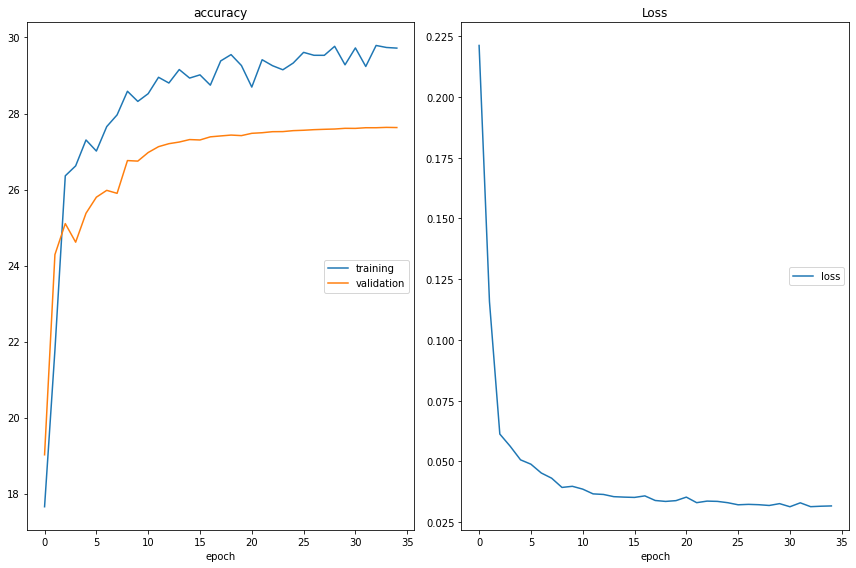

accuracy
	training         	 (min:   17.657, max:   29.790, cur:   29.721)
	validation       	 (min:   19.023, max:   27.636, cur:   27.631)
Loss
	loss             	 (min:    0.031, max:    0.221, cur:    0.032)
The baseline PSNR of baboon is 24.854883193969727
The PSNR of baboon is 25.24704360961914


In [12]:
"""Auxiliary script for running ZSSR train & eval for a single image 
In this node you may try the experiment on different images.
You may add / remove keys from the configuration dictionary as you see fit.
"""
from experiment import Experiment

config = {
  'scale_factor': 2, # scale factor - DO NOT CHANGE
  'device': 'cuda' if torch.cuda.is_available() else 'cpu',
  'verbose': True,
  'lr': 0.0001, # learning rate
  'random_crop_size': 100, #crop size inputted to the model
  'epochs': 3500, # number of epochs to run
  'show_interval': 100 # plot after this number of epochs
}

experiment = Experiment(utils.DATA_ROOT, config)
# choose some exemplary image
train_path, gt_path = experiment.train_paths[0], experiment.gt_paths[0]
assert train_path.name == gt_path.name
curr_model = experiment.train(train_path)
curr_psnr = experiment.evaluate(gt_path, curr_model)
baseline_psnr = experiment.baseline(gt_path)

# plot results
print(f"The baseline PSNR of {gt_path.stem} is {baseline_psnr}")
print(f"The PSNR of {gt_path.stem} is {curr_psnr}")

In [13]:
# playground for debugging experiment
from experiment import Experiment


# Your ZSSR

Please include a brief description of your ZSSR model, including where you implemented <font color='red'>`basic`</font>, <font color='green'>`advanced`</font>, or <font color='blue'>`original`</font>. If you implemented original components add a short explanation of what you did and why. 

Double click on the following cell in order to edit it.

---

I implemented only Basic - Basic data handling and basic ZSSRNet. 

The basic ZSSRNet is, as required, a fully convolutional network with 8 layers, 64 channels each, and kernels of size 3x3.

It was enough to beat the baseline PSNR on all images :)

---

# (D) Benchmark Experiment
In the following cells you create a benckmark on a given dataset. The results will be visible in the notebook as well as in `dataset_psnr.csv`.

**NOTE:** The benchmark script may run for a while - up to 2-3 minutes per image. However, there is no need for it to take any longer. If you find your code still takes longer despite using GPUs try changing your solution. 

In [14]:
config['verbose'] = False # no plotting

experiment = Experiment(utils.DATA_ROOT, config)
run_df = experiment.run()
run_df

0it [00:00, ?it/s]

baboon.png


1it [00:38, 38.40s/it]

baby.png


2it [01:18, 38.87s/it]

barbara.png


3it [02:05, 41.26s/it]

bird.png


4it [02:37, 38.53s/it]

butterfly.png


5it [03:08, 36.23s/it]

coastguard.png


6it [03:40, 34.96s/it]

face.png


7it [04:11, 33.92s/it]

flowers.png


8it [04:48, 34.71s/it]

foreman.png


9it [05:20, 34.10s/it]

head.png


10it [05:52, 33.33s/it]

lenna.png


11it [06:31, 35.01s/it]

man.png


12it [07:08, 35.74s/it]

monarch.png


13it [07:55, 39.04s/it]

pepper.png


14it [08:36, 39.49s/it]

woman.png


15it [09:07, 36.53s/it]


,image_path,psnr,baseline
0,baboon.png,25.195953,24.854883
1,baby.png,37.162285,37.109322
2,barbara.png,28.365725,28.000767
3,bird.png,38.664062,36.834541
4,butterfly.png,31.645166,27.433338
5,coastguard.png,29.806837,29.133217
6,face.png,35.230347,34.865910
7,flowers.png,32.035515,30.374056
8,foreman.png,35.190285,34.014317
9,head.png,35.304897,34.892532


In [ ]:
#@title # Create and Download Your Solution
import os
import re
import zipfile
from google.colab import files

os.chdir('..')

def create_zip(files, hw, name):
  zip_path = f'{hw}-{name}.zip'
  with zipfile.ZipFile(zip_path, 'w') as f:
    for fname in files:
      if not os.path.isfile(fname):
        os.chdir('./zssr')
        raise FileNotFoundError(f"Couldn't find file: '{fname}' in the homework directory")
      f.write(fname, fname)
  return zip_path
# export notebook as html
!jupyter nbconvert --to html hw3.ipynb
!jupyter nbconvert --to html zssr/main.ipynb
##@markdown Please upload your typed solution (`.pdf` file) to the homework directory, and use the name `hw2-sol.pdf`.
student_name = "Itai Antebi"  #@param{type:"string"}
assignment_name = 'hw3'
assignment_sol_files = ['hw3.ipynb', 'hw3.html', 'autograd.py', 'functional.py',
                        'nn.py', 'optim.py',
                        'models.py', 'train.py', 
                        'hw2_nn.py', 'hw2_functional.py', 'hw2_optim.py',
                        'hw3-sol.pdf', 'zssr/main.ipynb', 'zssr/main.html',
                        'zssr/models.py', 'zssr/data_handling.py',
                        'zssr/experiment.py', 'zssr/data_psnr.csv']
zip_name = re.sub('[_ ]+', '_', re.sub(r'[^a-zA-Z_ ]+', '', student_name.lower()))
# create zip with your solution
zip_path = create_zip(assignment_sol_files, assignment_name, zip_name)
# download the zip
files.download(zip_path)

os.chdir('./zssr')
#@markdown Enter your name in `student_name` and run this cell to create and download a `.zip` file with your solution.
#@markdown You should submit your solution via the Dropbox link given in Piazza.

#@markdown **Note:** If you run this cell multiple times, you may be prompted by the browser to allow this page to download multiple files.